<img src="https://upload.wikimedia.org/wikipedia/en/a/a1/Visma_logo.jpg"
     align="right"
     width="30%"
     alt="Visma logo">

Classification Workflow 
=============

<img src="http://www.rm.dk/siteassets/regional-udvikling/digitalisering/dabai/dabai-logo.png"
     align="right"
     width="20%"
     alt="DABAI logo">
     
The following notebook shows how the workflow for classification should be executed.

In [1]:
%run -i initilization.py

In [2]:
from classification.ExecuteClassificationWorkflow import ExecuteWorkflowClassification
import classification.CreateParametersClasification as create_params
from shared import GeneralDataImport
from IPython.display import display

### Import data and select columns for id and features
__Rembember to click Import file!__

In [3]:
data_import = GeneralDataImport.GeneralDataImport(parquet_path+'/merged_cvr.parquet')

In [4]:
data_import.select_columns()

###  Lets divide the data into a training- and test-set. 

We'll use the training-set for a K-fold-cross validation later on. 
__Note:__ our dataset has 3 lables: 0, 1 and 2. We'll also filter out label 2, since it only shows companies with funny status'.

In [12]:
from pyspark.sql import functions as F

train_df, test_df = (data_import
                     .data_frame
                     .filter(F.col('label') < 2.0)
                     .randomSplit([0.66, 0.33])
                    )

#print(data_import.list_features)
print('Number of training points are {}'.format(train_df.count()))
print('Number of test points are {}'.format(test_df.count()))
train_df.limit(5).toPandas()
#train_df.printSchema()

Number of training points are 108490
Number of test points are 54117


,cvr,status,kortBeskrivelse,navn,label,AarsVaerk_1,AarsVaerk_2,AarsVaerk_3
0,10000122,org.apache.spark.sql.catalyst.expressions.Unsa...,APS,DIGITAL CENTER FYN,1.0,1.0,2.0,1.0
1,10000653,org.apache.spark.sql.catalyst.expressions.Unsa...,A/S,SCSK 3241,0.0,1.0,1.0,1.0
2,10000661,org.apache.spark.sql.catalyst.expressions.Unsa...,A/S,SCSK 3243,0.0,1.0,2.0,5.0
3,10000815,org.apache.spark.sql.catalyst.expressions.Unsa...,APS,E B J KOLDING,0.0,1.0,2.0,2.0
4,10002729,org.apache.spark.sql.catalyst.expressions.Unsa...,APS,DOD.COM,0.0,1.0,1.0,1.0


### Select an algorithm and its parameters

In [13]:
selector = create_params.ParamsClassification()
params = selector.select_parameters()
display(params)

__For verification:__

In [14]:
parameter_dict = selector.output_parameters(params)
parameter_dict

{'algorithm': 'LogisticRegression',
 'elasticNetParam': (0.0, 0.5),
 'fitIntercept': True,
 'labelCol': 'label',
 'maxIter': (100, 150),
 'predictionCol': 'prediction',
 'probabilityCol': 'probability',
 'rawPredictionCol': 'rawPrediction',
 'regParam': (0.0, 0.5),
 'threshold': (0.0, 0.5),
 'tol': (1e-06, 0.01)}

### Initilize the workflow class
We have all the ingredients needed to make the Pipeline

In [15]:
model = ExecuteWorkflowClassification(
    parameter_dict,
    data_import.standardize,
    data_import.list_features
)

### Execute the pipeline in a K-fold cross-validation
In this case, we execute the Pipeline both with and without the K-fold cross-validation, in order to examine the differences.

In [16]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
result_model = model.pipeline.fit(train_df)
crossfitted_model = model.run_cross_val(
    train_df,
    BinaryClassificationEvaluator(),
    3
)
#summary = fitted_data.bestModel.stages[-1].summary

In [17]:
df_no_cv_pipeline = (result_model.transform(test_df))
l = model.pipeline.getStages()[-1].getLabelCol()
p = model.pipeline.getStages()[-1].getPredictionCol()
df_confusion = df_no_cv_pipeline.groupBy([l,p]).count()
df_confusion.toPandas()

,label,prediction,count
0,1.0,1.0,10
1,0.0,1.0,21
2,1.0,0.0,10240
3,0.0,0.0,43846


### Lets look at the ROC-curve:

The area under the curve is 0.5812158275012296


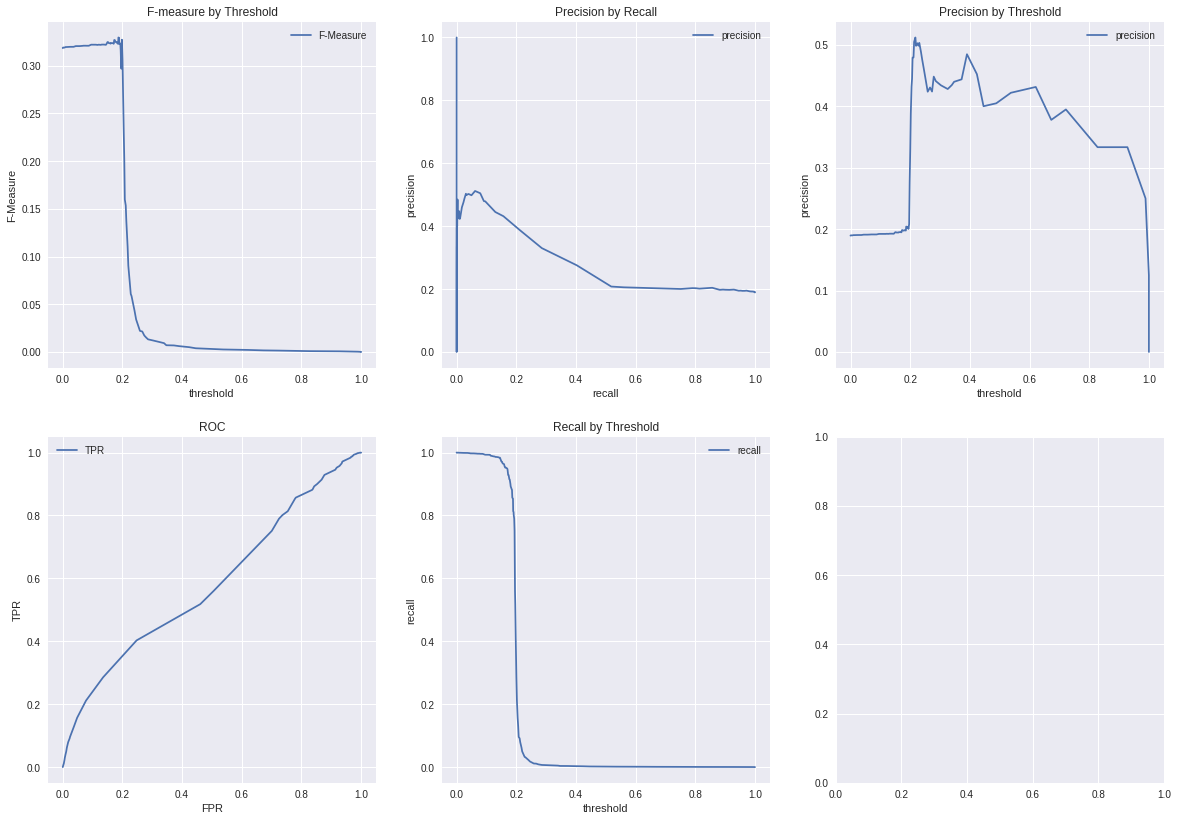

In [19]:
if crossfitted_model.bestModel.stages[-1].hasSummary:
    fig, axes = plt.subplots(
        nrows=2,
        ncols=3,
        figsize=(20, 14))
    summary = crossfitted_model.bestModel.stages[-1].summary
    
    
    print('The area under the curve is {}'.format(summary.areaUnderROC))
    attributes = []
    titles = ['F-measure by Threshold','Precision by Recall','Precision by Threshold', 'ROC', 'Recall by Threshold']
    attributes.append(summary.fMeasureByThreshold.toPandas())
    attributes.append(summary.pr.toPandas())
    attributes.append(summary.precisionByThreshold.toPandas())
    attributes.append(summary.roc.toPandas())
    attributes.append(summary.recallByThreshold.toPandas())
    #iterations = summary.totalIterations
    
    jdx = 0
    for idx, data_frame in enumerate(attributes):
        if idx % 3 == 0 and idx != 0:
            jdx+=1
        ax = axes[jdx,idx % 3]
        ax.plot(data_frame.columns[0],
                data_frame.columns[1],
                data=data_frame,                
               )
        ax.legend()
        ax.set_xlabel(data_frame.columns[0])
        ax.set_ylabel(data_frame.columns[1])
        ax.set_title(titles[idx])
    plt.show()

In [25]:
from classification import ShowClassification

In [24]:
show_classification_attributes(crossfitted_model)

LogisticRegression_48c3af93ae350da50350